# 加载与函数

In [1]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import seaborn as sns
import tensorflow as tf
from sklearn import svm
from subprocess import call
from scipy import signal
from sklearn import tree
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import numpy as np
import warnings
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate

from WindPy import w
w.start()
#趋势划分函数

from numpy import exp, array, random, dot
#激活函数及坡度
def sig(x):
    return 1 / (1 + exp(-x))

def sig_drv(x):
    return x * (1-x)

#生成初始神经网络
def gen_layer(x,y,nnum):
    res = [2 * random.random((len(x[0]), nnum[0])) - 1]
    if len(nnum) > 1:
        for i in range(1,len(nnum)):
            res.append(2 * random.random((nnum[i-1], nnum[i])) - 1)
    res.append(2 * random.random((nnum[-1], len(y[0]))) - 1)
    return res

#输入结果
def calc(x, nn):
    res = []
    for i in range(len(nn)):
        if i == 0:
            res.append(sig(dot(x, nn[i])))
        else:
            res.append(sig(dot(res[-1], nn[i])))
    return res

#纠正
def correct(x, y, nnum, time,prt):
    layer = gen_layer(x,y,nnum)
    for j in range(time):
        res = calc(x, layer)
        det = []
        err = []
        adj = []
        for i in range(len(layer)-1,-1,-1):
            if i == len(layer)-1:
                err.append(y - res[-1])
                det.append(err[0] * sig_drv(res[-1]))
            else:
                err.append(det[-1].dot((layer[i+1]).T))
                det.append(err[-1] * sig_drv(res[i]))
        
        det = det[::-1]
        for i in range(len(det)):
            if i == 0:
                adj.append((x.T).dot(det[i]))
            else:
                adj.append((res[i-1].T).dot(det[i]))        
        for i in range(len(layer)):
            layer[i] += adj[i]
    if prt:
        print(layer)
    return layer

def und(dat, l1, l2):
    
    i = 0
    res = [0] * len(dat)

    while i < len(dat)-1:
        if i + l1 >= len(dat) - 1 - l2:
            for j in range(i, len(dat)-l2):
                res[j] = res[i]
            break
        cur = dat[i]
        next_id = min([(dat[i+1:]).index(max(dat[i+1+l1:i+1+l2])), (dat[i+1:]).index(min(dat[i+1+l1:i+1+l2]))]) +i+1
        res[i:next_id+1] = [- (-1) ** (dat[next_id] > dat[i])] * (next_id + 1 - i)
        i = next_id
    return res

#清理重复的月份
def date_clean(date,data):
    date_res = [date[0]]
    data_res = [[i[0]] for i in data]
    
    last = date[0]
    
    for i in range(len(date[1:])):
        cur = date[i]
        if cur.month != last.month:
            date_res.append(cur)
            for j in range(len(data_res)):
                data_res[j].append(data[j][i])
        last = date[i]

    return date_res, data_res

#时间序列模型预测
def ts_predict(data, date, n_steps):
    
    f, err95, ci95 = best_mdl.forecast(steps=n_steps)
    idx = [date[-1]]
    for i in range(n_steps-1):
        idx.append(next_month(idx[-1]))
    fc_all = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
    return fc_all['forecast'][1]

#移动平均线MA
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x]/d1[i1-x-l_roc]-1)/l_sma
    return res

#KST公式
def kst(d2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    res = []
    for i in range(roc_l4+sma_l4, len(d2)):
        rocma1 = rocsma(d2,i,roc_l1,sma_l1)
        rocma2 = rocsma(d2,i,roc_l2,sma_l2)
        rocma3 = rocsma(d2,i,roc_l3,sma_l3)
        rocma4 = rocsma(d2,i,roc_l4,sma_l4)
        res.append(rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    return res
    
#斜率
def slope(data):
    res = [0]
    for i in range(1,len(data)):
        res.append(-(-1) ** (data[i]>data[i-1]))
    res[0] = res[1]
    return res
    
#获取下个月末
def next_month(date):
    if date.month == 12:
        res = date.replace(year = date.year + 1, month = 1, day = calendar.monthrange(int(date.year+1), 1)[1])
        
    else:
        res = date.replace(month = date.month + 1, day = calendar.monthrange(int(date.year), date.month + 1)[1])
        
    return res

#相对强度
def rel_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

#训练与验证集
def trvd(x, y, ratio):
    train_x = x[:int(len(x)*ratio)]
    valid_x = x[int(len(x)*ratio):]
    train_y = y[:int(len(x)*ratio)]
    valid_y = y[int(len(x)*ratio):]
    
    print(len(train_x), len(valid_x), len(train_y), len(valid_y))
    return train_x, valid_x, train_y, valid_y

#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#大小对比
def comp(d1,d2):
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#标准化
def std(data):
    res = []
    for i in range(len(data)):
        res.append((data[i] - np.mean(data[:i+1]))/np.mean(data[:i+1]))
    return res

#普林格经济周期
def pring(b,s,c):
    if b == 1 and s == c == -1:
        return -3
    if b == s == 1 and c == -1:
        return -1
    if b == s == c == 1:
        return 1
    if b == -1 and s == c == 1:
        return 3
    if b == s == -1 and c == 1:
        return 1
    if b == s == c == -1:
        return -1
    else:
        return 0

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

def data_pro(data,l):
    df = []
    #从第l个周期开始
    for i in range(l-1,len(date)):
        temp = []

        for j in range(len(data)):
            i = int(i)
            j = int(j)
            #选取第j组第i+l时间点前l长度的数据
            il = data[j][i-l+1:i+1]

            #第i+l时间点前l长度的涨跌幅度及方向————0
            temp.append(il[-1]/il[0]-1)

            #第i+l时间点前l长度内的最大波动幅度————1
            temp.append(((max(il)-min(il))/np.mean(il)))

            #第i+l时间点前l长度内的反转频率————2
            spike = 0
            dirc = -(-1) ** (il[1] > il[0]) 
            for k in range(1,l):
                spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
                dirc = -(-1) ** (il[k] > il[k-1])
            temp.append(spike/l)

            #第i+l时间点的数据，并根据之前的平均值标准化————3
            temp.append(data[j][i]/np.mean(data[j][:i])-1)
            
            #第i+l时间点l个时长的移动平均值，并根据之前的平均值标准化————4
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            #第i+l时间点6个时长的移动平均值，并根据之前的平均值标准化————5
            il = data[j][i-6+1:i+1]
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            #第i+l时间点9个时长的移动平均值，并根据之前的平均值标准化————6
            il = data[j][i-9+1:i+1]
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

             
        df.append(temp)
    return df

def data_pro_st(data,l):
    df = []
    #从第l个周期开始
    for i in range(l-1,len(date)):
        temp = []

        for j in range(len(data)):
            i = int(i)
            j = int(j)
            #选取第j组第i+l时间点前l长度的数据
            il = data[j][i-l+1:i+1]

            #第i+l时间点前一、两个时间点的涨跌幅度及方向————0,1
            temp.append(il[-1]/(il[-2]+.0001)-1)
            temp.append(il[-1]/(il[-3]+.0001)-1)
            
            #第i+l时间点前l长度内的最大波动幅度————2
            temp.append(((max(il)-min(il))/np.mean(il)))

            #第i+l时间点前l长度内的反转频率————3
            spike = 0
            dirc = -(-1) ** (il[1] > il[0]) 
            for k in range(1,l):
                spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
                dirc = -(-1) ** (il[k] > il[k-1])
            temp.append(spike/l)

            #第i+l时间点l个时长的移动平均值，并根据之前的平均值标准化————4
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            #第i+l时间点的数据，并根据之前的平均值标准化————5
            temp.append(data[j][i]/np.mean(data[j][:i])-1)

            #第i+l时间点6个时长的移动平均值，并根据之前的平均值标准化————6
            il = data[j][i-6+1:i+1]
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            #第i+l时间点9个时长的移动平均值，并根据之前的平均值标准化————7
            il = data[j][i-9+1:i+1]
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

             
        df.append(temp)
    return df

def data_pro_supa(data,l):
    df = []
    #从第l个周期开始
    for i in range(l-1,len(date)):
        temp = []

        for j in range(len(data)):
            i = int(i)
            j = int(j)
            #选取第j组第i+l时间点前l长度的数据
            il = data[j][i-l+1:i+1]

            #第i+l时间点前一、两个时间点的涨跌幅度及方向————0,1
            temp.append(il[-1]/(il[-2]+.0001)-1)
            temp.append(il[-1]/(il[-3]+.0001)-1)
            
            #第i+l时间点前l长度内的最大波动幅度————2
            temp.append(((max(il)-min(il))/np.mean(il)))

            #第i+l时间点前l长度内的反转频率————3
            spike = 0
            dirc = -(-1) ** (il[1] > il[0]) 
            for k in range(1,l):
                spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
                dirc = -(-1) ** (il[k] > il[k-1])
            temp.append(spike/l)

            #第i+l时间点l个时长的移动平均值，并根据之前的平均值标准化————4
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            #第i+l时间点的数据，并根据之前的平均值标准化————5
            temp.append(data[j][i]/np.mean(data[j][:i])-1)

            #第i+l时间点2个时长的移动平均值，并根据之前的平均值标准化————6
            il = data[j][i-2+1:i+1]
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

            #第i+l时间点3个时长的移动平均值，并根据之前的平均值标准化————7
            il = data[j][i-3+1:i+1]
            temp.append(np.mean(il)/np.mean(data[j][:i])-1)    

             
        df.append(temp)
    return df

def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data
    
def date2num(date):
    d8 = []
    for i in range(len(date)):
        d8.append(int((date[i] - date[0]).days))
    return d8
    
def find1y(date):
    last = date[0]
    for i in range(len(date)):
        cur = date[i]
        if cur.year != last.year:
            return i
        last = date[i]
######################################评估方式

#准确度计算
def acc(d1,d2):
    return round(sum(np.array(d1) == np.array(d2))/ len(d1),3)

#收益率计算
def profit(data, ud):
    money = 1
    num = 0
    prt = 0   #显示买卖记录
    m2y = 1   #是否年化收益
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
 
            num = money/(data[i]+.00001)
            money = 0
        if ud[i] == -1 and money == 0 and data[i] != 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print('结果',money+num*data[-1])
    if m2y:
        return (money+num*data[-1]) ** (1/len(data)*12)
    return money+num*data[-1]

#错误区间占比
def wrong_div(data, ud):
    c_div = 1
    c_wrong = 0
    l_wrong = 1
    l_all = 0
    dirc = ud[0]
    last = data[0]
    for i in range(1,len(data)):
        l_wrong += 1
        if ud[i] == 0:
            return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(data))
        if ud[i] != dirc:
            c_div += 1
            if -(-1)**(data[i] > last) != dirc:
                c_wrong += 1
                l_all += l_wrong
            l_wrong = 1
            last = data[i]
            dirc = ud[i]

    return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(data))

#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正态分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


random.seed(1)

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


# 读取数据与理想划分

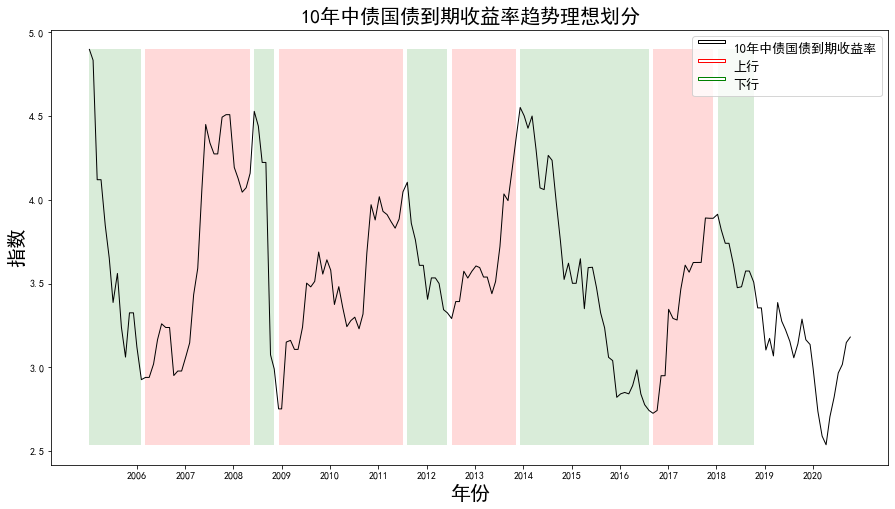

10年中债国债到期收益率理想年化收益率 11.596498082935124%


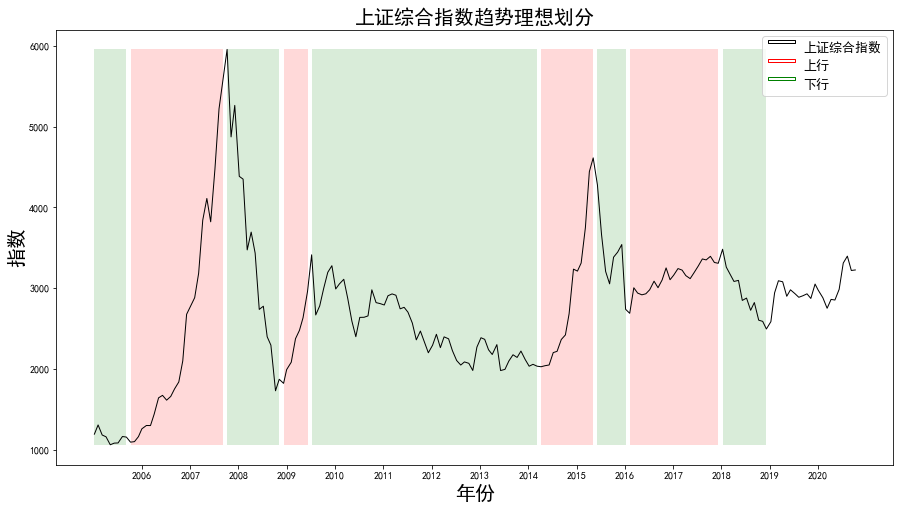

上证综合指数理想年化收益率 27.20780415559345%


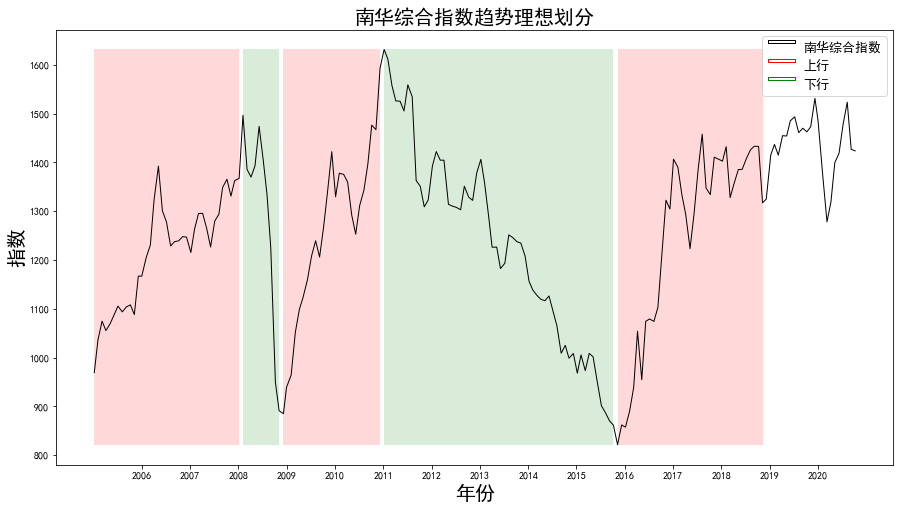

南华综合指数理想年化收益率 12.28335735759103%


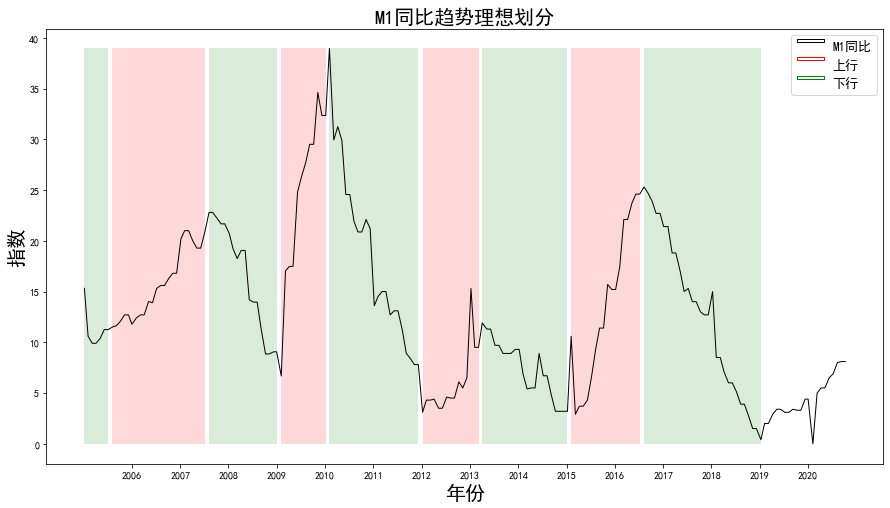

M1同比理想年化收益率 40.08482047307167%


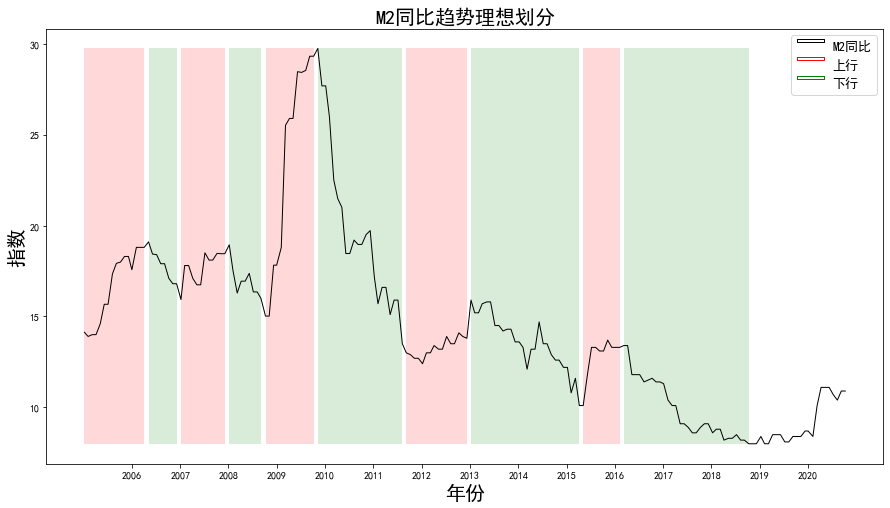

M2同比理想年化收益率 12.60026733797195%


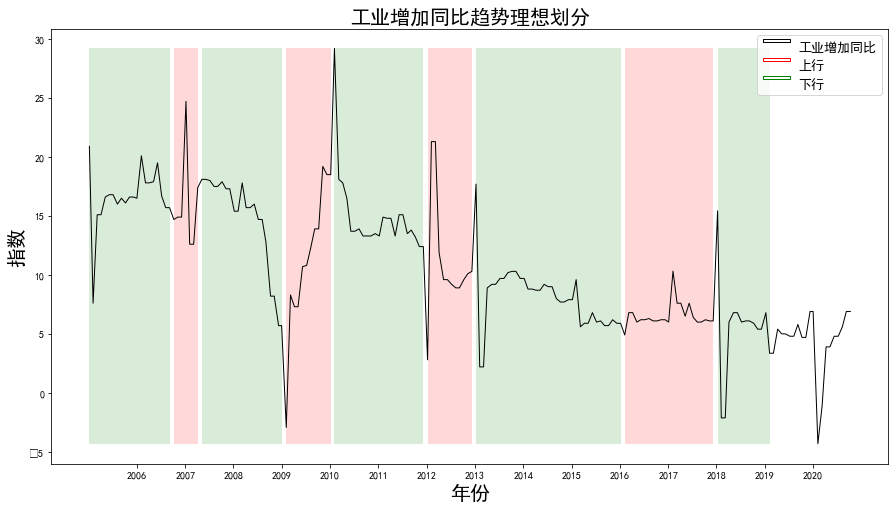

工业增加同比理想年化收益率 (44.97195262871716+33.50152366387036j)%


In [2]:
int_list = [['S0059749','10年中债国债到期收益率'],['M0020188','上证综合指数'],['S0105896','南华综合指数'],
            ['M0001383','M1同比'], ['M0001385','M2同比'],
            ['M0000545', '工业增加同比'],
            ['G1000116','OECD'],['M0017126','PMI']]

#起止时间
t0 = '2005-01-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'M'

#移动平均线平均时长
l = 12

ind_list = []
for i in int_list:
    ind_list.append(i[0])

og = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')


#指数与日期
date, data = date_clean(og.Times, og.Data)
date_s = [str(i) for i in date]
df = data_pro(data,l)
df_st = data_pro_st(data,l)
data_std = [std(i) for i in data]
data_ma = [ma(i,l) for i in data]

d8 = date2num(date)

#所选市场
for ii in range(6):
    ud = und(data[ii],6,24)

    plt.rcParams['font.family']=['SimHei']
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_title(int_list[ii][1]+'趋势理想划分',fontproperties='SimHei', size = 20)
    ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

    plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
    plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

    collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
    ax.add_collection(collection)

    colors = ['black', 'red', 'green']
    new_legends = ["-"] * len(colors)
    markers = ['-'] * len(colors)

    _, labels = ax.get_legend_handles_labels()

    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

    plt.show()
    print(int_list[ii][1]+'理想年化收益率',  str((profit(data[ii][:-24],ud[:-24]) - 1) * 100) + '%'   )

In [3]:
c = 0
name = []
oecd = std(data[-2])
oecd_ma = ma(oecd,12)
ud_oecd = comp(oecd[11:],oecd_ma)
for i in range(len(data)):
    exec('data'+str(i)+'=[j[7*i:7*(i+1)] for j in df]')
    
print('市场数量',i+1)
print('日期长度',len(d8))
print('市场数据范围', l, '~',l+len(data1)-1)
print('趋势划分范围',1, '~',len(ud[:ud.index(0)]))

市场数量 8
日期长度 190
市场数据范围 12 ~ 190
趋势划分范围 1 ~ 170


# 债券市场

In [4]:
ii = 0
ud = und(data[ii],6,24)
base_cpx = cpx(ud)

## 神经网络

[array([[-4.78676822],
       [-1.19769334],
       [10.6164731 ],
       [-7.66593174],
       [-6.18736453],
       [-2.67778813],
       [-2.01130927],
       [ 5.28248892]]), array([[-6.00976398]])]


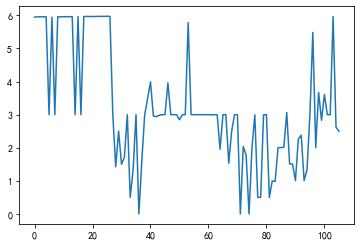

In [5]:
res_nnet1 = []

for i in range(48,len(d8)):
    temp = []
    
    cur_ud = und(data[ii][:i], 6, 24)
    cur_ud = cur_ud[11:cur_ud.index(0)]
    y = array([cur_ud]).T
    
    for j in range(len(data)):
        exec('x'+str(j)+'=array(data'+str(j)+'[:len(cur_ud)])')
        temp.append(sum(calc(eval('data'+ str(j))[i-17:i-11], correct(eval('x'+str(j)), y, [5], 500, 0))[-1])[0])
    res_nnet1.append(temp)
    
res_nnet2 = []
for i in range(84,len(date)):
    cur_ud = und(data[ii][48:i], 6, 24)
    cur_ud = cur_ud[:cur_ud.index(0)]
    x = array(res_nnet1[:len(cur_ud)])
    y = array([cur_ud]).T
    res_nnet2.append(sum(calc(res_nnet1[i-54:i-48], correct(x, y, [1], 500, 0))[-1]))
calc(x[-6:], correct(x, y, [1], 50, 1))[:0]
plt.plot(res_nnet2)
plt.show()

年化收益率 2.25%
相对收益率 0.213
准确率 0.561
复杂度 5.736
区间错误率 ('17/32', '53/106')


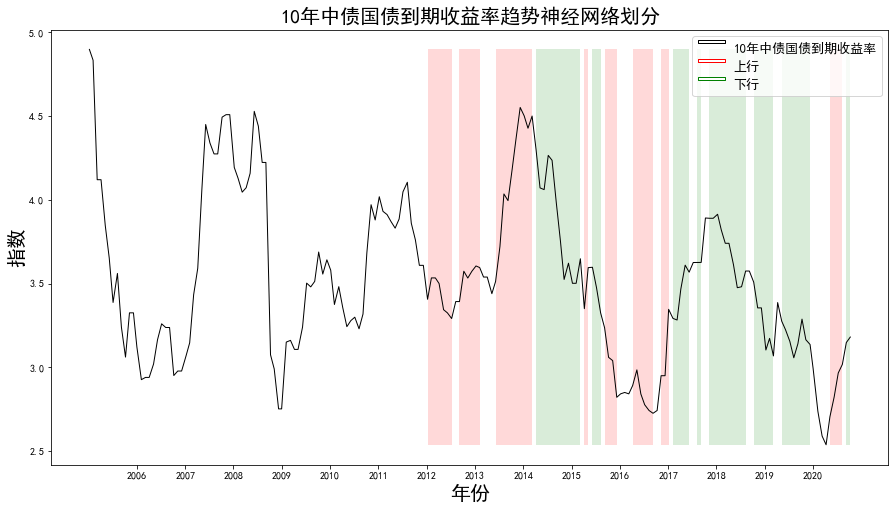

In [6]:
temp = -(-1) ** (np.array([i[0] for i in res_nnet2]) >= 3)
l_n = len(d8) - len(temp)
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势神经网络划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)/(profit(data['+ str(ii) +'][l_n:-24], ud[l_n:-24]) -1) ,3)')
exec('a'+str(c)+'= round(acc(temp[:-24], ud[l_n:-24]),3)')
exec('c'+str(c)+'= round(cpx(temp)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_n:], temp)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('债券市场——神经网络')
plt.show()

## 随机森林

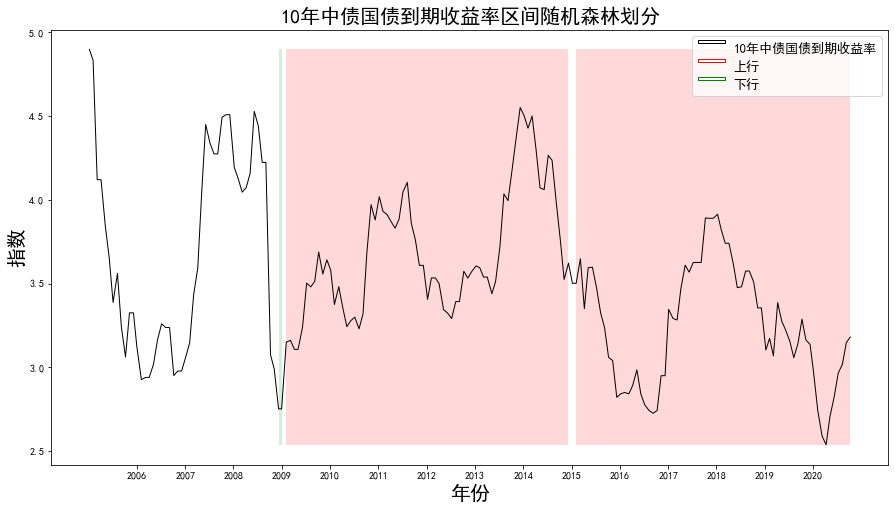

年化收益率 0.08%
相对收益率 0.01
准确率 0.538
复杂度 0.531
区间错误率 ('1/4', '3/143')


In [7]:
data_bond = [i[ii*7:(ii*7+7)] for i in df]
rf_prd = []
rf = RandomForestRegressor(n_estimators = 200)
for i in range(47,len(date)):
    cur_ud = und(data[ii][:i],6,24)
    rf.fit(data_bond[:cur_ud.index(0)-11], cur_ud[11:cur_ud.index(0)])
    rf_prd.append(-(-1)**(sum(np.array(rf.predict(data_bond[cur_ud.index(0)-11:i]))) >= 0)  )

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'区间随机森林划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_rf = len(d8) - len(rf_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)


_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)/(profit(data['+ str(ii) +'][l_rf:-24], ud[l_rf:-24])-1),2)')
exec('a'+str(c)+'= round(acc(rf_prd[:-24], ud[l_rf:-24]),3)')
exec('c'+str(c)+'= round(cpx(rf_prd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_rf:], rf_prd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('债券市场——随机森林')

## 移动平均

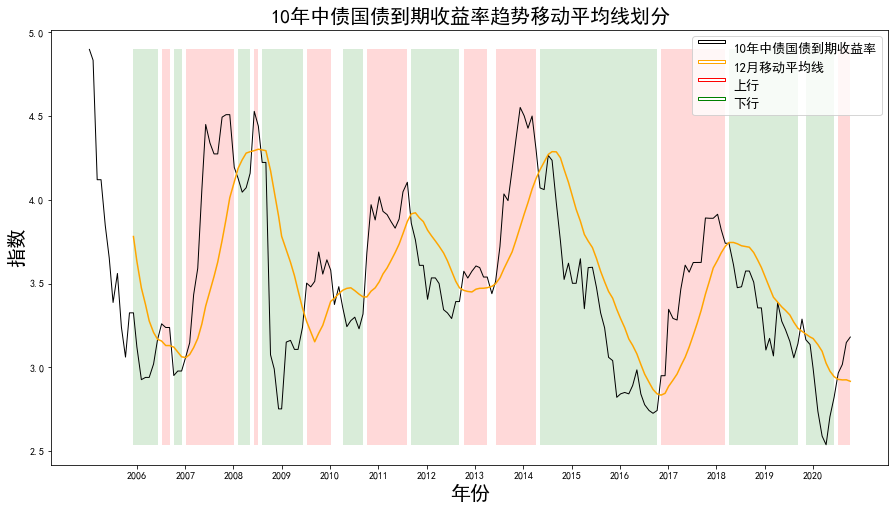

年化收益率 3.27%
相对收益率 0.262
准确率 0.631
复杂度 2.335
区间错误率 ('11/22', '47/179')


In [8]:
ma_b = ma(data[ii],12)
ud_ma_b = comp(data[ii][l-1:],ma_b)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势移动平均线划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8[l-1:], ma(data[ii],l), color = 'orange', label = '12月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'orange', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1) /(profit(data['+ str(ii) +'][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+' = round(acc(ud_ma_b,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_ma_b)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l-1:], ud_ma_b)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('债券市场——移动平均')

## KST

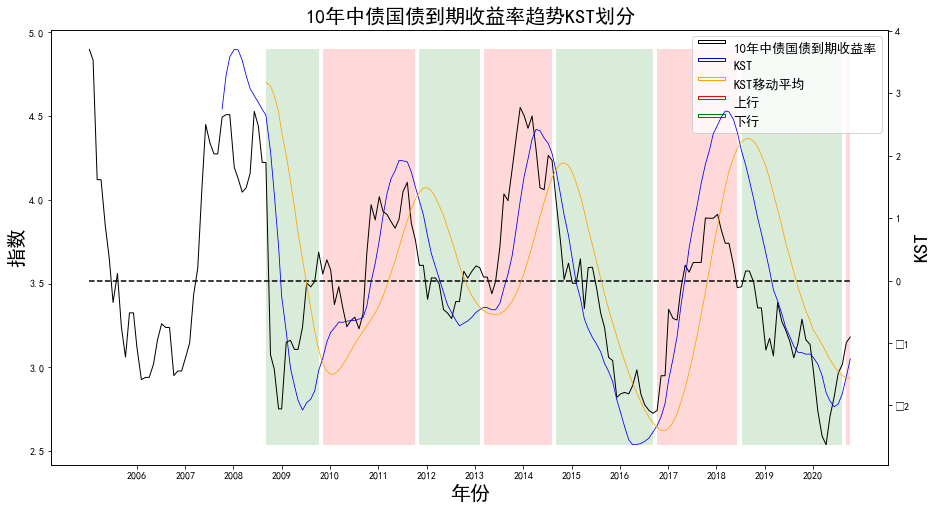

年化收益率 3.18%
相对收益率 0.283
准确率 0.575
复杂度 1.041
区间错误率 ('0/8', '0/146')


In [9]:
data_kst = kst(data[ii],9,12,18,24,6,6,6,9)
kst_ma = ma(data_kst,12)
ud_kst = comp(data_kst[11:], kst_ma)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势KST划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8, data[ii], color='blue', linewidth = 0, label = 'KST')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'KST移动平均')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_kst = len(d8) - len(ud_kst)

ax2 = ax.twinx()
ax2.plot(d8[len(d8) - len(data_kst):], data_kst, color='b', linewidth = .8)
ax2.plot(d8[len(d8) - len(kst_ma):], kst_ma, color='orange', linewidth = .8)
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")
plt.ylabel(u'KST',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l_kst:], ud_kst)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data[ii][l_kst:], ud_kst)-1) /(profit(data[ii][l_kst:-24], ud[l_kst:-24])-1)    ,3)')
exec('a'+str(c)+'=round(acc(ud_kst,ud[l_kst:]),3)')
exec('c'+str(c)+'= round(cpx(ud_kst)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l_kst:], ud_kst)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('债券市场——KST')

## OECD

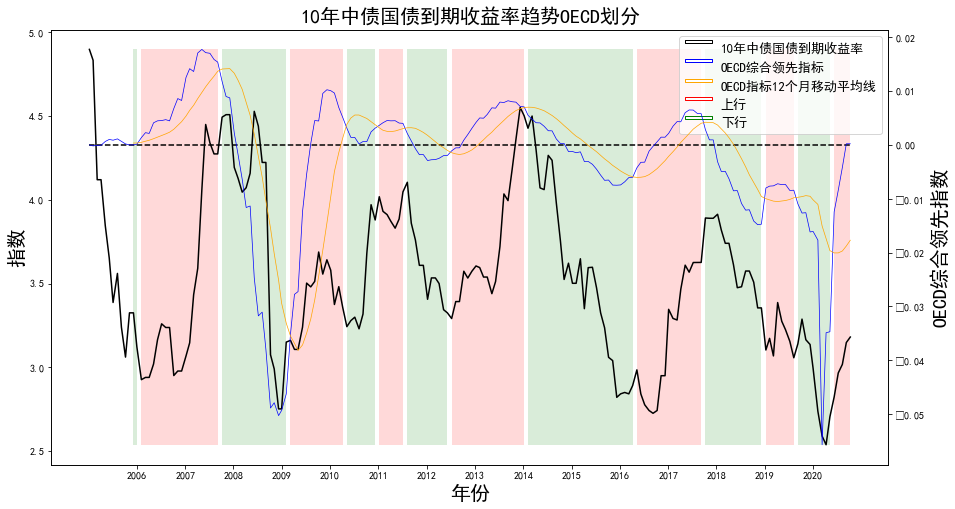

年化收益率 8.15%
相对收益率 0.654
准确率 0.813
复杂度 1.486
区间错误率 ('1/14', '9/179')


In [10]:
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势OECD划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1.5, label = int_list[ii][1])
ax.plot(d8, data[ii], color ='blue', linewidth = 0, label = 'OECD综合领先指标')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'OECD指标12个月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

ax2 = ax.twinx()
ax2.plot(d8, oecd, color='b', linewidth = .7, label = 'OECD综合领先指标')
ax2.plot(d8[l-1:], oecd_ma, color='orange', linewidth = .7, label = '12个月移动平均线')
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")

plt.ylabel(u'OECD综合领先指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ['-'] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)/(profit(data[ii][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+'= round(acc(ud_oecd[:-24],ud[l-1:-24]),3)')
exec('c'+str(c)+'= round(cpx(ud_oecd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l-1:], ud_oecd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('债券市场——OECD')

# 股票市场

In [11]:
ii = 1
ud = und(data[ii],6,24)
base_cpx = cpx(ud)

## 神经网络

[array([[ 0.94068638],
       [ 9.06952224],
       [-1.6523649 ],
       [ 2.24290534],
       [ 1.32968782],
       [-2.12303408],
       [-1.85741229],
       [-0.92312531]]), array([[-16.44047407]])]


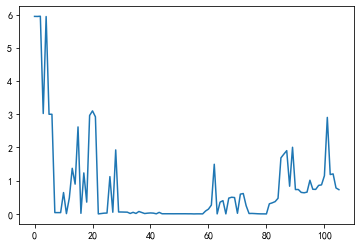

In [12]:
res_nnet1 = []

for i in range(48,len(d8)):
    temp = []
    
    cur_ud = und(data[ii][:i], 6, 24)
    cur_ud = cur_ud[11:cur_ud.index(0)]
    y = array([cur_ud]).T
    
    for j in range(len(data)):
        exec('x'+str(j)+'=array(data'+str(j)+'[:len(cur_ud)])')
        temp.append(sum(calc(eval('data'+ str(j))[i-17:i-11], correct(eval('x'+str(j)), y, [5], 500, 0))[-1])[0])
    res_nnet1.append(temp)
    
res_nnet2 = []
for i in range(84,len(date)):
    cur_ud = und(data[ii][48:i], 6, 24)
    cur_ud = cur_ud[:cur_ud.index(0)]
    x = array(res_nnet1[:len(cur_ud)])
    y = array([cur_ud]).T
    res_nnet2.append(sum(calc(res_nnet1[i-54:i-48], correct(x, y, [1], 500, 0))[-1]))
calc(x[-6:], correct(x, y, [1], 50, 1))[:0]
plt.plot(res_nnet2)
plt.show()

年化收益率 3.59%
相对收益率 0.226
准确率 0.415
复杂度 3.764
区间错误率 ('10/21', '64/106')


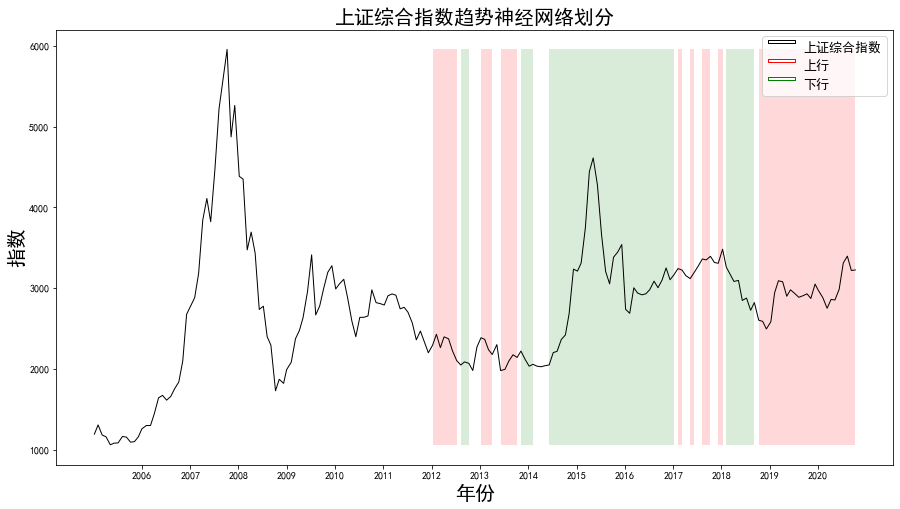

In [13]:
temp = -(-1) ** (np.array([i[0] for i in res_nnet2]) >= .25)
l_n = len(d8) - len(temp)
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势神经网络划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)/(profit(data['+ str(ii) +'][l_n:-24], ud[l_n:-24]) -1) ,3)')
exec('a'+str(c)+'= round(acc(temp[:-24], ud[l_n:-24]),3)')
exec('c'+str(c)+'= round(cpx(temp)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_n:], temp)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
plt.show()
name.append('股票市场——神经网络')

## 随机森林

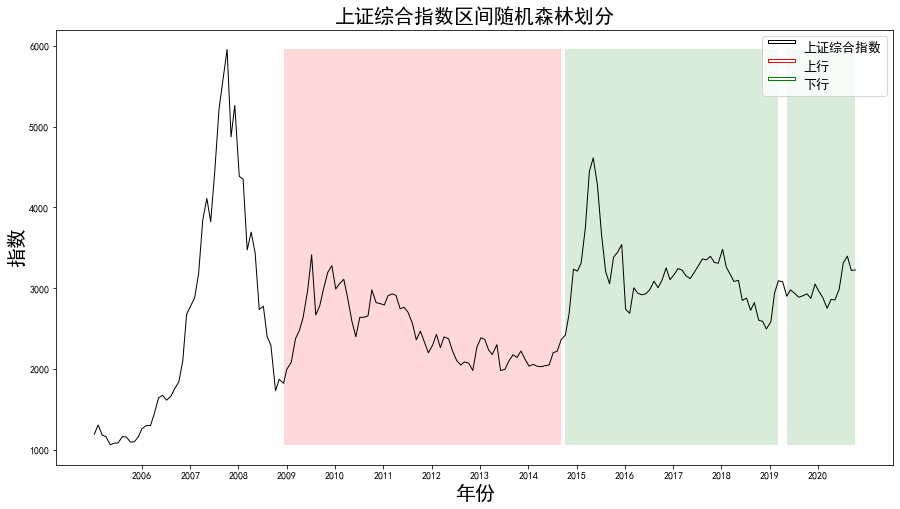

年化收益率 1.9%
相对收益率 0.11
准确率 0.261
复杂度 0.531
区间错误率 ('2/4', '57/143')


In [14]:
data_bond = [i[ii*7:(ii*7+7)] for i in df]

rf_prd = []
rf = RandomForestRegressor(n_estimators = 200)
for i in range(47,len(date)):
    cur_ud = und(data[ii][:i],6,24)
    rf.fit(data_bond[:cur_ud.index(0)-11], cur_ud[11:cur_ud.index(0)])
    rf_prd.append(-(-1)**(sum(np.array(rf.predict(data_bond[cur_ud.index(0)-11:i]))) >= 0)  )

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'区间随机森林划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_rf = len(d8) - len(rf_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)


_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)/(profit(data['+ str(ii) +'][l_rf:-24], ud[l_rf:-24])-1),2)')
exec('a'+str(c)+'= round(acc(rf_prd[:-24], ud[l_rf:-24]),3)')
exec('c'+str(c)+'= round(cpx(rf_prd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_rf:], rf_prd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('股票市场——随机森林')

## 移动平均

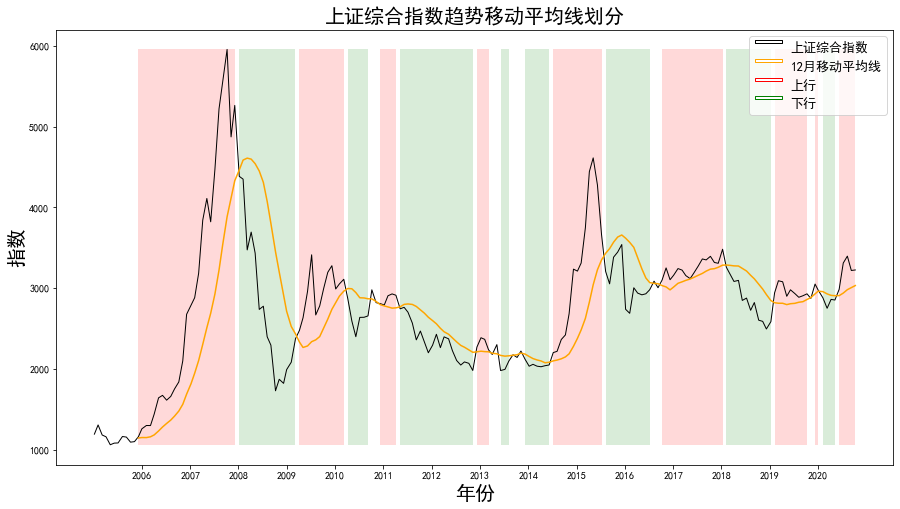

年化收益率 10.86%
相对收益率 0.377
准确率 0.642
复杂度 2.866
区间错误率 ('17/27', '66/179')


In [15]:
ma_b = ma(data[ii],12)
ud_ma_b = comp(data[ii][l-1:],ma_b)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势移动平均线划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8[l-1:], ma(data[ii],l), color = 'orange', label = '12月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'orange', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1) /(profit(data['+ str(ii) +'][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+' = round(acc(ud_ma_b,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_ma_b)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l-1:], ud_ma_b)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('股票市场——移动平均')

## KST

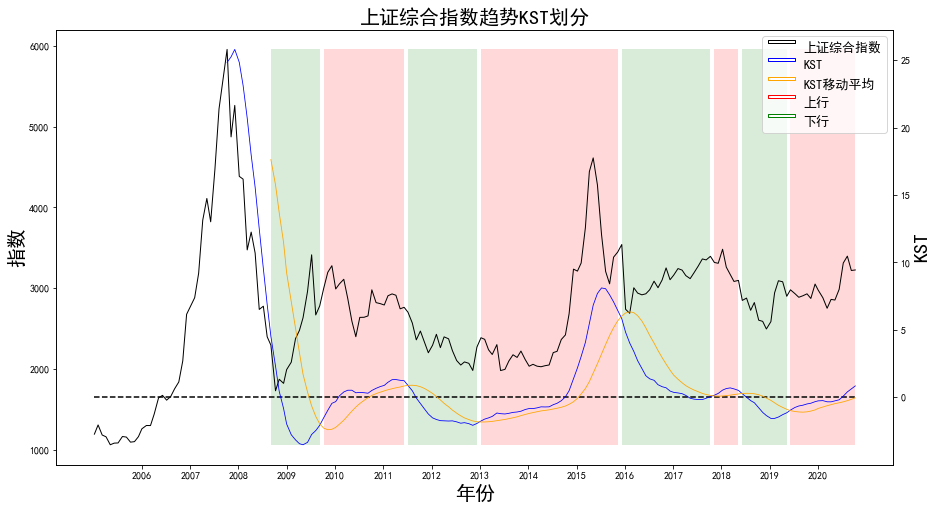

年化收益率 1.81%
相对收益率 0.104
准确率 0.336
复杂度 1.041
区间错误率 ('4/8', '57/146')


In [16]:
data_kst = kst(data[ii],9,12,18,24,6,6,6,9)
kst_ma = ma(data_kst,12)
ud_kst = comp(data_kst[11:], kst_ma)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势KST划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8, data[ii], color='blue', linewidth = 0, label = 'KST')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'KST移动平均')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_kst = len(d8) - len(ud_kst)

ax2 = ax.twinx()
ax2.plot(d8[len(d8) - len(data_kst):], data_kst, color='b', linewidth = .8)
ax2.plot(d8[len(d8) - len(kst_ma):], kst_ma, color='orange', linewidth = .8)
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")
plt.ylabel(u'KST',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l_kst:], ud_kst)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data[ii][l_kst:], ud_kst)-1) /(profit(data[ii][l_kst:-24], ud[l_kst:-24])-1)    ,3)')
exec('a'+str(c)+'=round(acc(ud_kst,ud[l_kst:]),3)')
exec('c'+str(c)+'= round(cpx(ud_kst)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l_kst:], ud_kst)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('股票市场——KST')

## OECD

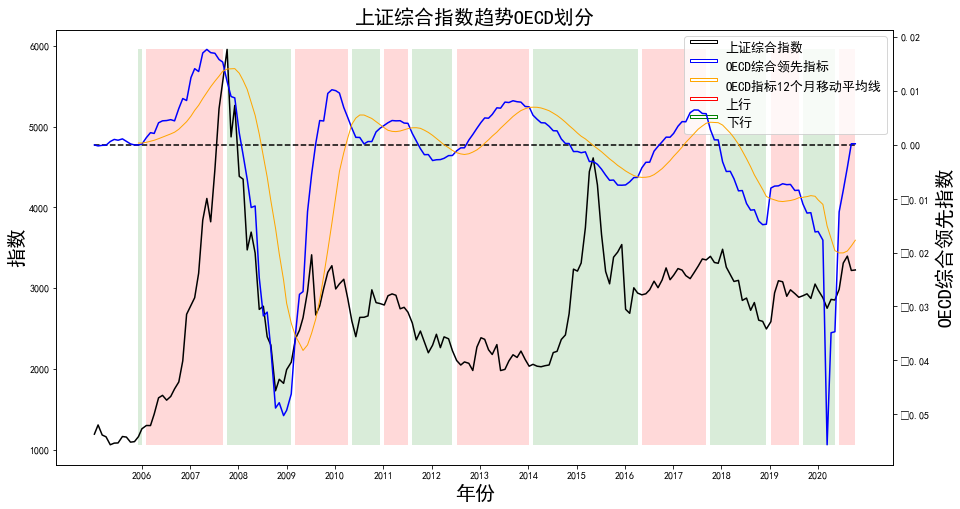

年化收益率 13.21%
相对收益率 0.459
准确率 0.536
复杂度 1.486
区间错误率 ('6/14', '78/179')


In [17]:
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势OECD划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1.5, label =int_list[ii][1])
ax.plot(d8, data[ii], color ='blue', linewidth = 0, label = 'OECD综合领先指标')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'OECD指标12个月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

ax2 = ax.twinx()
ax2.plot(d8, oecd, color='b', linewidth = 1.5, label = 'OECD综合领先指标')
ax2.plot(d8[l-1:], oecd_ma, color='orange', linewidth = 1, label = '12个月移动平均线')
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")

plt.ylabel(u'OECD综合领先指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ['-'] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)/(profit(data[ii][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+'= round(acc(ud_oecd,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_oecd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l-1:], ud_oecd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('股票市场——OECD')

# 商品市场

In [18]:
ii = 2
ud = und(data[ii],6,24)
base_cpx = cpx(ud)

## 神经网络

[array([[4.41197233],
       [1.05195846],
       [3.87836152],
       [0.74428733],
       [0.66002377],
       [4.11780557],
       [3.18177506],
       [3.1276254 ]]), array([[-13.0601161]])]


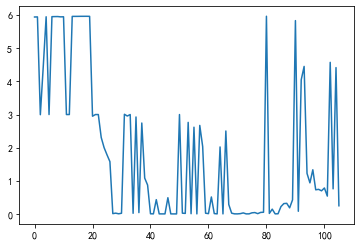

In [19]:
res_nnet1 = []

for i in range(48,len(d8)):
    temp = []
    
    cur_ud = und(data[ii][:i], 6, 24)
    cur_ud = cur_ud[11:cur_ud.index(0)]
    y = array([cur_ud]).T
    
    for j in range(len(data)):
        exec('x'+str(j)+'=array(data'+str(j)+'[:len(cur_ud)])')
        temp.append(sum(calc(eval('data'+ str(j))[i-17:i-11], correct(eval('x'+str(j)), y, [5], 500, 0))[-1])[0])
    res_nnet1.append(temp)
    
res_nnet2 = []
for i in range(84,len(date)):
    cur_ud = und(data[ii][48:i], 6, 24)
    cur_ud = cur_ud[:cur_ud.index(0)]
    x = array(res_nnet1[:len(cur_ud)])
    y = array([cur_ud]).T
    res_nnet2.append(sum(calc(res_nnet1[i-54:i-48], correct(x, y, [1], 500, 0))[-1]))
calc(x[-6:], correct(x, y, [1], 50, 1))[:0]
plt.plot(res_nnet2)
plt.show()

年化收益率 1.36%
相对收益率 0.161
准确率 0.744
复杂度 8.365
区间错误率 ('11/28', '48/106')


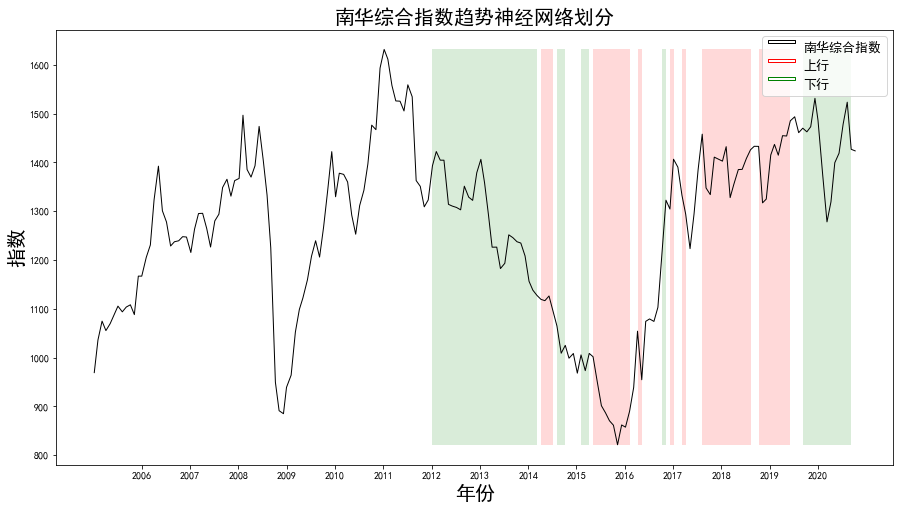

In [20]:
temp = (-1) ** (np.array([i[0] for i in res_nnet2]) >= .5)
l_n = len(d8) - len(temp)
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势神经网络划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)/(profit(data['+ str(ii) +'][l_n:-24], ud[l_n:-24]) -1) ,3)')
exec('a'+str(c)+'= round(acc(temp[:-24], ud[l_n:-24]),3)')
exec('c'+str(c)+'= round(cpx(temp)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_n:], temp)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

plt.show()

name.append('商品市场——神经网络')

## 随机森林

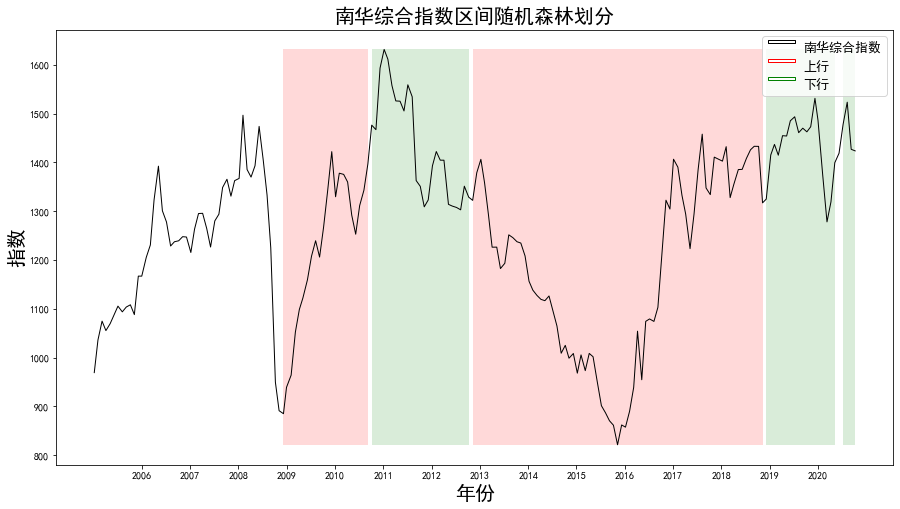

年化收益率 4.77%
相对收益率 0.38
准确率 0.672
复杂度 1.329
区间错误率 ('1/6', '19/143')


In [21]:
data_bond = [i[ii*7:(ii*7+7)] for i in df]

rf_prd = []
rf = RandomForestRegressor(n_estimators = 200)
for i in range(47,len(date)):
    cur_ud = und(data[ii][:i],6,24)
    rf.fit(data_bond[:cur_ud.index(0)-11], cur_ud[11:cur_ud.index(0)])
    rf_prd.append(-(-1)**(sum(np.array(rf.predict(data_bond[cur_ud.index(0)-11:i]))) >= 0)  )

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'区间随机森林划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_rf = len(d8) - len(rf_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)


_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)/(profit(data['+ str(ii) +'][l_rf:-24], ud[l_rf:-24])-1),2)')
exec('a'+str(c)+'= round(acc(rf_prd[:-24], ud[l_rf:-24]),3)')
exec('c'+str(c)+'= round(cpx(rf_prd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_rf:], rf_prd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('商品市场——随机森林')

## 移动平均

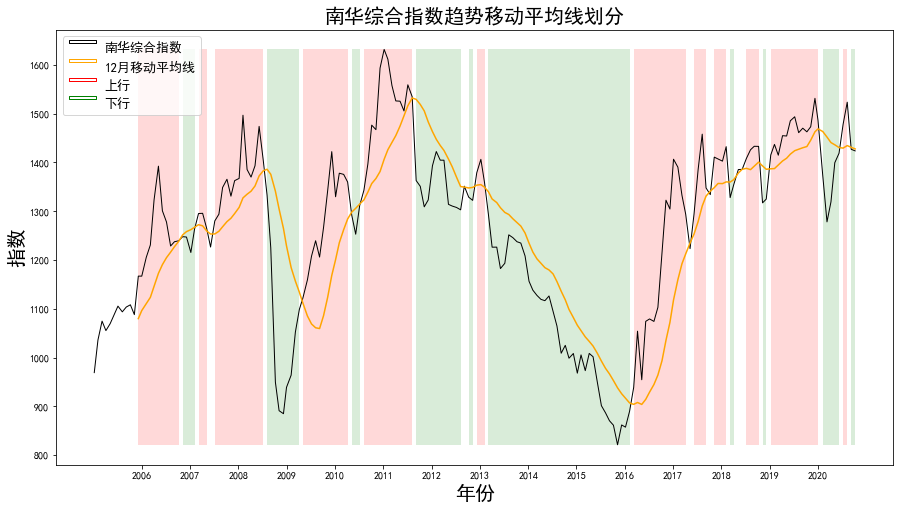

年化收益率 1.55%
相对收益率 0.134
准确率 0.642
复杂度 4.953
区间错误率 ('17/28', '69/179')


In [22]:
ma_b = ma(data[ii],12)
ud_ma_b = comp(data[ii][l-1:],ma_b)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势移动平均线划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8[l-1:], ma(data[ii],l), color = 'orange', label = '12月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'orange', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1) /(profit(data['+ str(ii) +'][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+' = round(acc(ud_ma_b,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_ma_b)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l-1:], ud_ma_b)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('商品市场——移动平均')

## KST

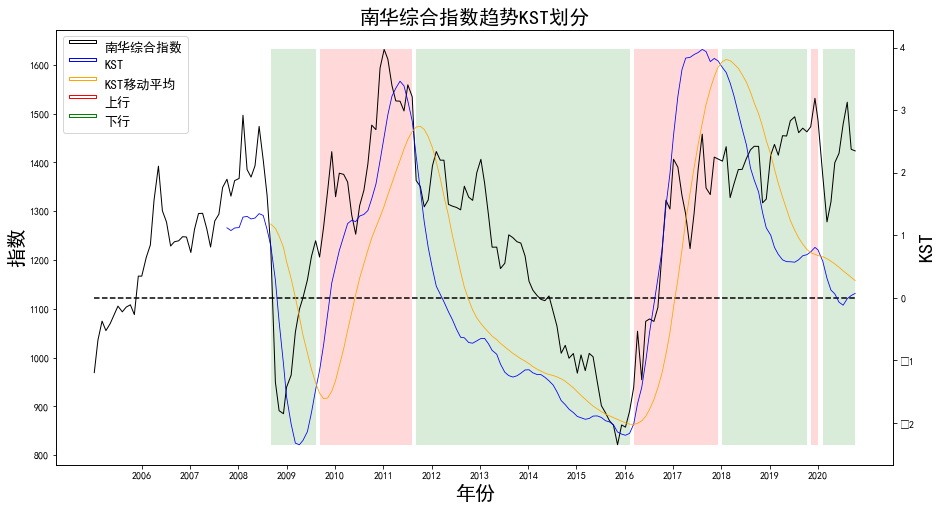

年化收益率 3.8%
相对收益率 0.312
准确率 0.623
复杂度 1.518
区间错误率 ('2/7', '27/146')


In [23]:
data_kst = kst(data[ii],9,12,18,24,6,6,6,9)
kst_ma = ma(data_kst,12)
ud_kst = comp(data_kst[11:], kst_ma)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势KST划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8, data[ii], color='blue', linewidth = 0, label = 'KST')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'KST移动平均')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_kst = len(d8) - len(ud_kst)

ax2 = ax.twinx()
ax2.plot(d8[len(d8) - len(data_kst):], data_kst, color='b', linewidth = .8)
ax2.plot(d8[len(d8) - len(kst_ma):], kst_ma, color='orange', linewidth = .8)
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")
plt.ylabel(u'KST',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l_kst:], ud_kst)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data[ii][l_kst:], ud_kst)-1) /(profit(data[ii][l_kst:-24], ud[l_kst:-24])-1)    ,3)')
exec('a'+str(c)+'=round(acc(ud_kst,ud[l_kst:]),3)')
exec('c'+str(c)+'= round(cpx(ud_kst)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l_kst:], ud_kst)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('商品市场——KST')

## OECD

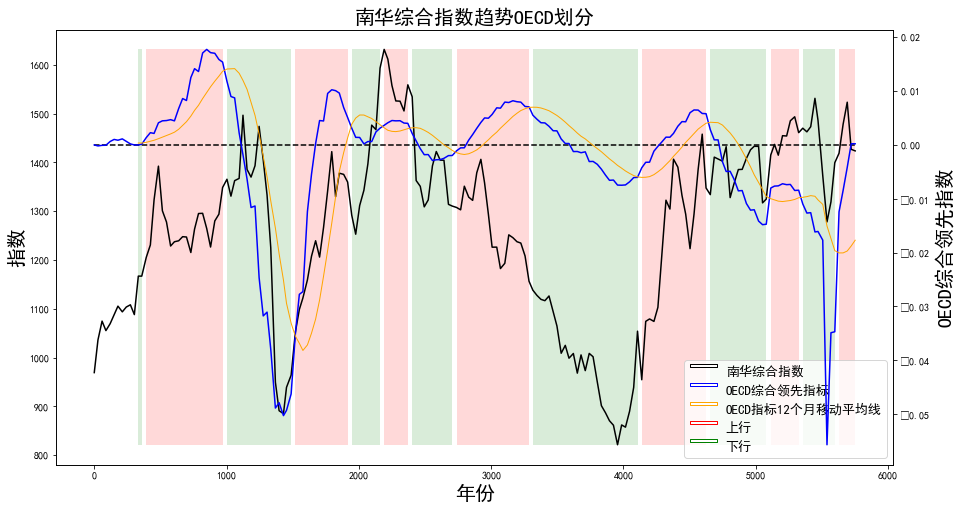

年化收益率 3.45%
相对收益率 0.298
准确率 0.52
复杂度 2.477
区间错误率 ('5/14', '56/179')


In [24]:
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势OECD划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1.5, label =int_list[ii][1])
ax.plot(d8, data[ii], color ='blue', linewidth = 0, label = 'OECD综合领先指标')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'OECD指标12个月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

ax2 = ax.twinx()
ax2.plot(d8, oecd, color='b', linewidth = 1.5, label = 'OECD综合领先指标')
ax2.plot(d8[l-1:], oecd_ma, color='orange', linewidth = 1, label = '12个月移动平均线')
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")

plt.ylabel(u'OECD综合领先指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ['-'] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)/(profit(data[ii][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+'= round(acc(ud_oecd,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_oecd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l-1:], ud_oecd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('商品市场——OECD')

# M1

In [25]:
ii = 3
ud = und(data[ii],6,24)
base_cpx = cpx(ud)

## 神经网络

[array([[3.36342202],
       [1.92394138],
       [1.92259218],
       [2.0537081 ],
       [4.91973697],
       [0.58018892],
       [0.7902042 ],
       [0.61200741]]), array([[-12.20350262]])]


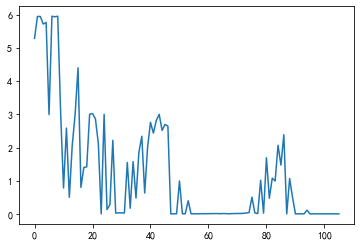

In [26]:
res_nnet1 = []

for i in range(48,len(d8)):
    temp = []
    
    cur_ud = und(data[ii][:i], 6, 24)
    cur_ud = cur_ud[11:cur_ud.index(0)]
    y = array([cur_ud]).T
    
    for j in range(len(data)):
        exec('x'+str(j)+'=array(data'+str(j)+'[:len(cur_ud)])')
        temp.append(sum(calc(eval('data'+ str(j))[i-17:i-11], correct(eval('x'+str(j)), y, [5], 500, 0))[-1])[0])
    res_nnet1.append(temp)
    
res_nnet2 = []
for i in range(84,len(date)):
    cur_ud = und(data[ii][48:i], 6, 24)
    cur_ud = cur_ud[:cur_ud.index(0)]
    x = array(res_nnet1[:len(cur_ud)])
    y = array([cur_ud]).T
    res_nnet2.append(sum(calc(res_nnet1[i-54:i-48], correct(x, y, [1], 500, 0))[-1]))
calc(x[-6:], correct(x, y, [1], 50, 1))[:0]
plt.plot(res_nnet2)
plt.show()

年化收益率 13.85%
相对收益率 0.362
准确率 0.695
复杂度 3.943
区间错误率 ('11/22', '32/106')


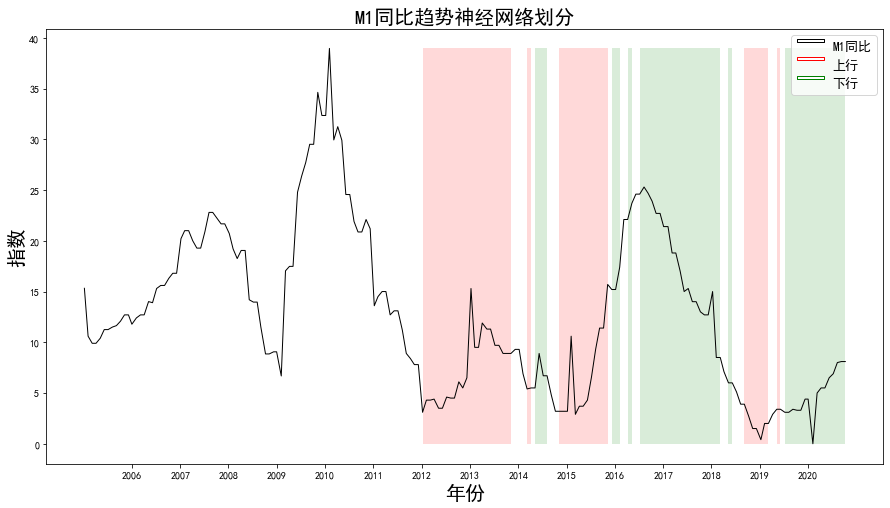

In [27]:
temp = -(-1) ** (np.array([i[0] for i in res_nnet2]) >= .25)
l_n = len(d8) - len(temp)
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势神经网络划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label =int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)/(profit(data['+ str(ii) +'][l_n:-24], ud[l_n:-24]) -1) ,3)')
exec('a'+str(c)+'= round(acc(temp[:-24], ud[l_n:-24]),3)')
exec('c'+str(c)+'= round(cpx(temp)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_n:], temp)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
plt.show()

name.append('M1——神经网络')

## 随机森林

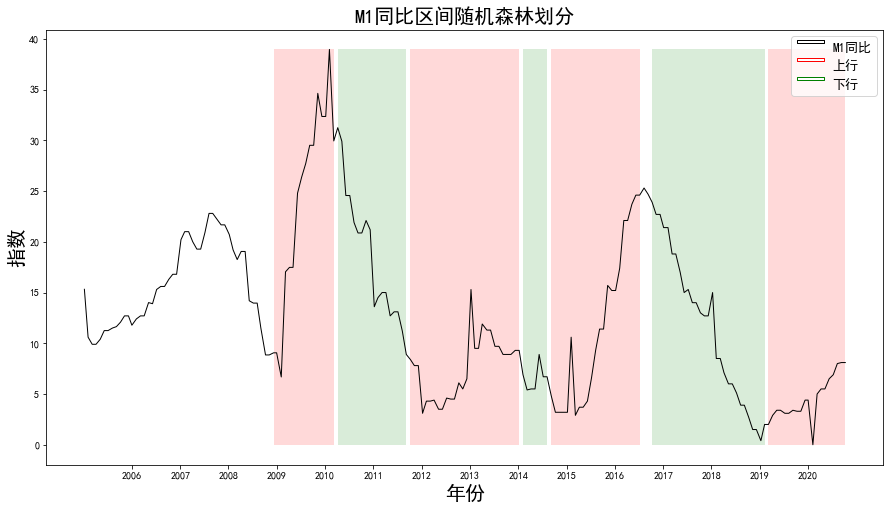

年化收益率 40.7%
相对收益率 0.82
准确率 0.807
复杂度 1.196
区间错误率 ('2/9', '31/143')


In [28]:
data_bond = [i[ii*7:(ii*7+7)] for i in df]

rf_prd = []
rf = RandomForestRegressor(n_estimators = 100)
for i in range(47,len(date)):
    cur_ud = und(data[ii][:i],6,24)
    rf.fit(data_bond[:cur_ud.index(0)-11], cur_ud[11:cur_ud.index(0)])
    rf_prd.append(-(-1)**(sum(np.array(rf.predict(data_bond[cur_ud.index(0)-11:i]))) >= 0)  )

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'区间随机森林划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_rf = len(d8) - len(rf_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)


_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)/(profit(data['+ str(ii) +'][l_rf:-24], ud[l_rf:-24])-1),2)')
exec('a'+str(c)+'= round(acc(rf_prd[:-24], ud[l_rf:-24]),3)')
exec('c'+str(c)+'= round(cpx(rf_prd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_rf:], rf_prd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('M1——随机森林')

## 短期数据随机森林

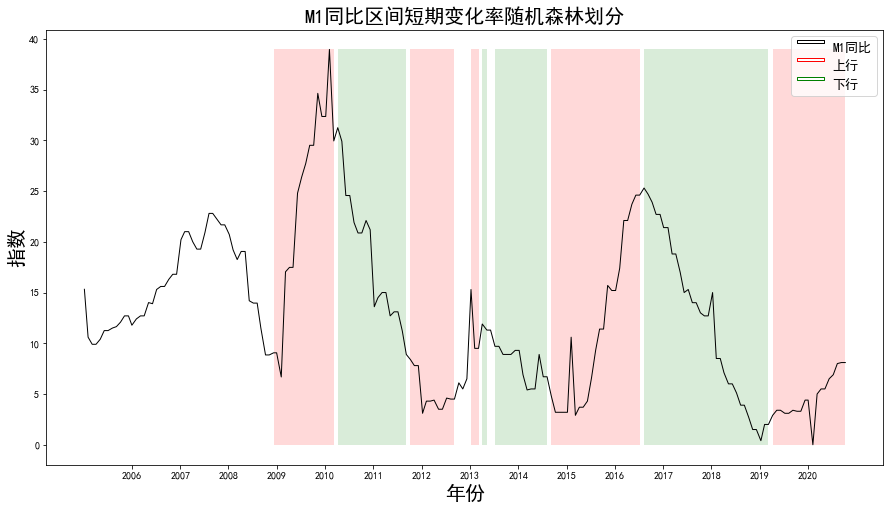

年化收益率 32.69%
相对收益率 0.66
准确率 0.874
复杂度 1.727
区间错误率 ('4/13', '21/143')


In [29]:
data_bond = [i[ii*8:(ii*8+8)] for i in df_st]

rf_prd = []
rf = RandomForestRegressor(n_estimators = 100)
for i in range(47,len(date)):
    cur_ud = und(data[ii][:i],6,24)
    rf.fit(data_bond[:cur_ud.index(0)-11], cur_ud[11:cur_ud.index(0)])
    rf_prd.append(-(-1)**(sum(np.array(rf.predict(data_bond[cur_ud.index(0)-11:i]))) >= 0)  )

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'区间短期变化率随机森林划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_rf = len(d8) - len(rf_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)


_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)/(profit(data['+ str(ii) +'][l_rf:-24], ud[l_rf:-24])-1),2)')
exec('a'+str(c)+'= round(acc(rf_prd[:-24], ud[l_rf:-24]),3)')
exec('c'+str(c)+'= round(cpx(rf_prd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_rf:], rf_prd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('M1——随机森林短期')

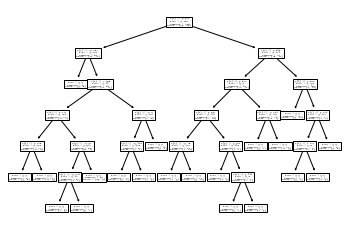

In [30]:
#树的可视化
tre = DecisionTreeClassifier()
tre.fit(data_bond[:-24], ud[11:-24])
tree.plot_tree(tre)
dot_data = tree.export_graphviz(tre, out_file="tre.dot") 

#dot -Tpng tre.dot -o tre.png

## 移动平均

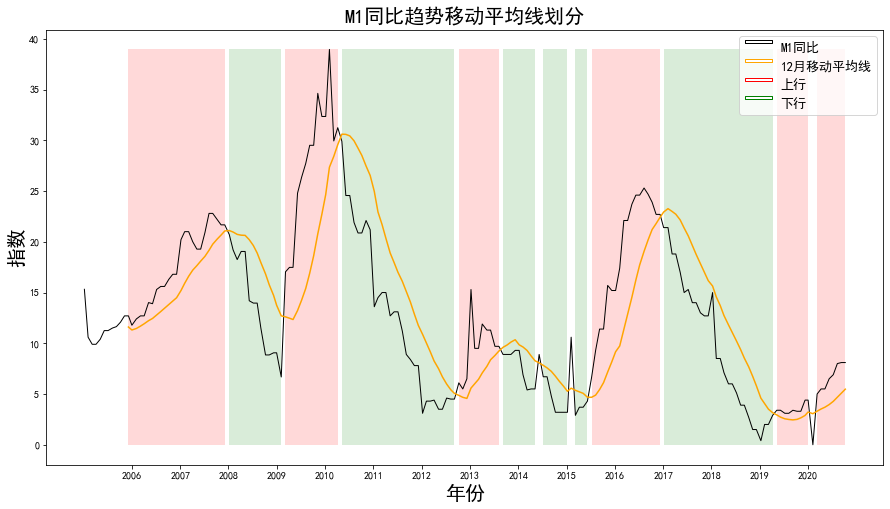

年化收益率 13.54%
相对收益率 0.319
准确率 0.698
复杂度 1.592
区间错误率 ('6/15', '29/179')


In [31]:
ma_b = ma(data[ii],12)
ud_ma_b = comp(data[ii][l-1:],ma_b)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势移动平均线划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8[l-1:], ma(data[ii],l), color = 'orange', label = '12月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'orange', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1) /(profit(data['+ str(ii) +'][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+' = round(acc(ud_ma_b,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_ma_b)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l-1:], ud_ma_b)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('M1——移动平均')

## KST

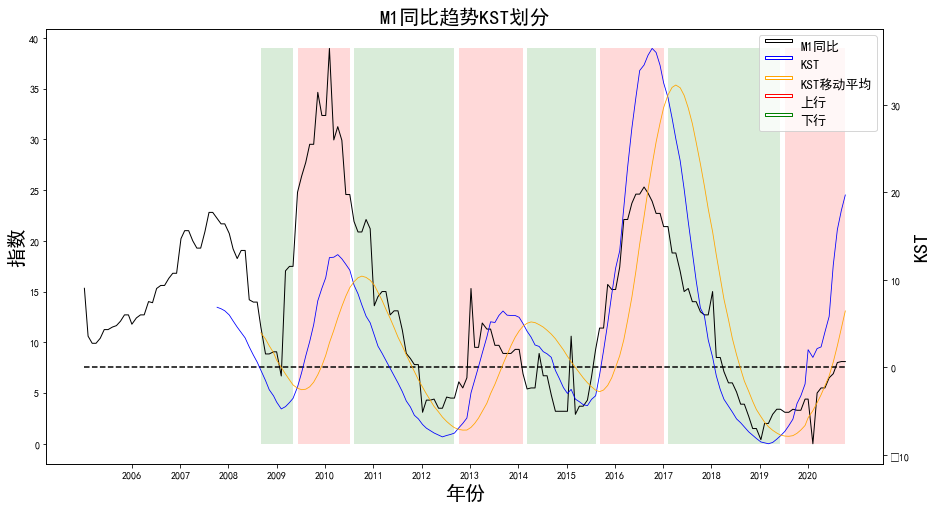

年化收益率 11.68%
相对收益率 0.244
准确率 0.562
复杂度 1.041
区间错误率 ('4/8', '62/146')


In [32]:
data_kst = kst(data[ii],9,12,18,24,6,6,6,9)
kst_ma = ma(data_kst,12)
ud_kst = comp(data_kst[11:], kst_ma)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势KST划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8, data[ii], color='blue', linewidth = 0, label = 'KST')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'KST移动平均')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_kst = len(d8) - len(ud_kst)

ax2 = ax.twinx()
ax2.plot(d8[len(d8) - len(data_kst):], data_kst, color='b', linewidth = .8)
ax2.plot(d8[len(d8) - len(kst_ma):], kst_ma, color='orange', linewidth = .8)
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")
plt.ylabel(u'KST',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l_kst:], ud_kst)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data[ii][l_kst:], ud_kst)-1) /(profit(data[ii][l_kst:-24], ud[l_kst:-24])-1)    ,3)')
exec('a'+str(c)+'=round(acc(ud_kst,ud[l_kst:]),3)')
exec('c'+str(c)+'= round(cpx(ud_kst)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l_kst:], ud_kst)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('M1——KST')

## OECD

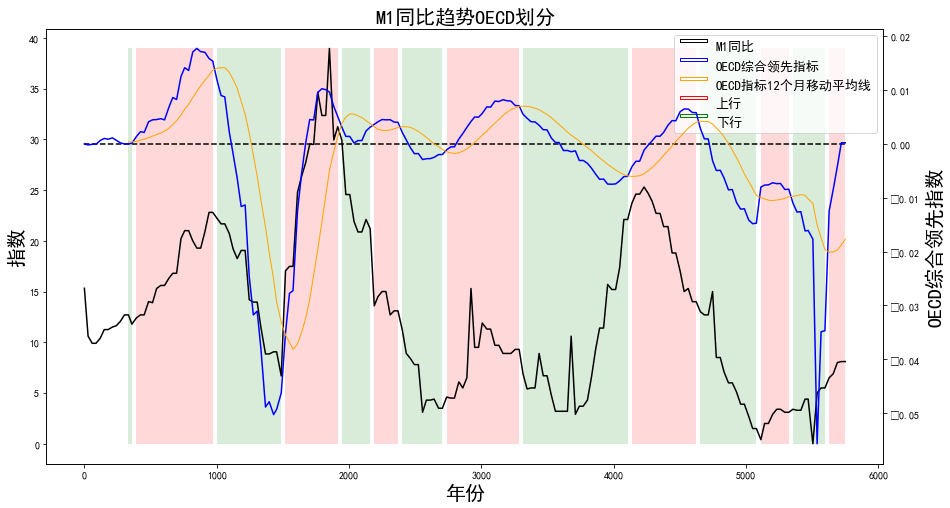

年化收益率 23.23%
相对收益率 0.548
准确率 0.542
复杂度 1.486
区间错误率 ('4/14', '64/179')


In [33]:
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势OECD划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1.5, label =int_list[ii][1])
ax.plot(d8, data[ii], color ='blue', linewidth = 0, label = 'OECD综合领先指标')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'OECD指标12个月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

ax2 = ax.twinx()
ax2.plot(d8, oecd, color='b', linewidth = 1.5, label = 'OECD综合领先指标')
ax2.plot(d8[l-1:], oecd_ma, color='orange', linewidth = 1, label = '12个月移动平均线')
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")

plt.ylabel(u'OECD综合领先指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ['-'] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)/(profit(data[ii][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+'= round(acc(ud_oecd,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_oecd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l-1:], ud_oecd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('M1——OECD')

# M2

In [34]:
ii = 4
ud = und(data[ii],6,24)
base_cpx = cpx(ud)

## 神经网络

[array([[ 3.11271386],
       [-7.36062906],
       [ 3.71099594],
       [-2.23625834],
       [ 2.95167707],
       [ 1.17308327],
       [-0.35143613],
       [ 0.03352656]]), array([[-13.17407315]])]


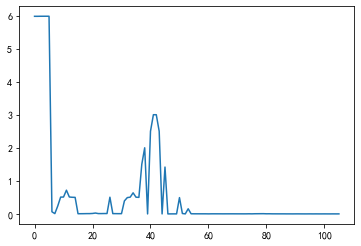

In [35]:
res_nnet1 = []

for i in range(48,len(d8)):
    temp = []
    
    cur_ud = und(data[ii][:i], 6, 24)
    cur_ud = cur_ud[11:cur_ud.index(0)]
    y = array([cur_ud]).T
    
    for j in range(len(data)):
        exec('x'+str(j)+'=array(data'+str(j)+'[:len(cur_ud)])')
        temp.append(sum(calc(eval('data'+ str(j))[i-17:i-11], correct(eval('x'+str(j)), y, [7], 500, 0))[-1])[0])
    res_nnet1.append(temp)
    
res_nnet2 = []
for i in range(84,len(date)):
    cur_ud = und(data[ii][48:i], 6, 24)
    cur_ud = cur_ud[:cur_ud.index(0)]
    x = array(res_nnet1[:len(cur_ud)])
    y = array([cur_ud]).T
    res_nnet2.append(sum(calc(res_nnet1[i-54:i-48], correct(x, y, [1], 500, 0))[-1]))
calc(x[-6:], correct(x, y, [1], 50, 1))[:0]
plt.plot(res_nnet2)
plt.show()

年化收益率 3.73%
相对收益率 0.461
准确率 0.744
复杂度 2.281
区间错误率 ('4/14', '20/106')


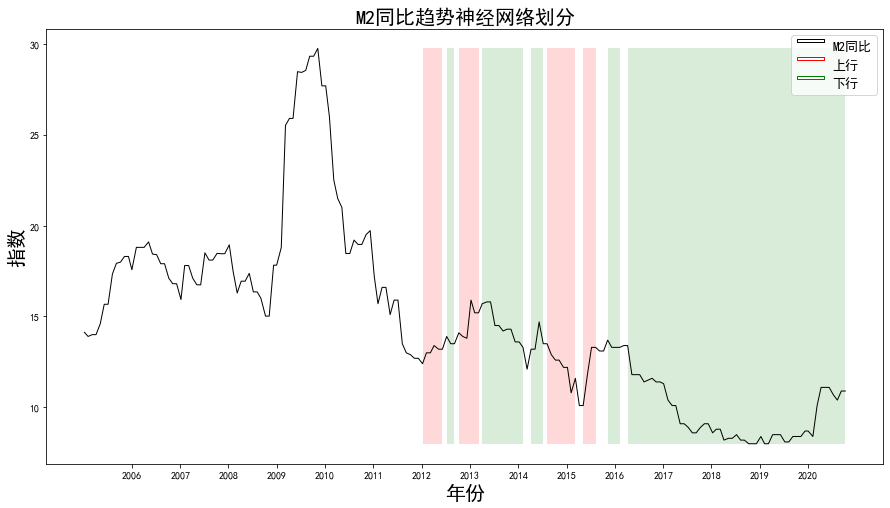

In [36]:
temp = -(-1) ** (np.array([i[0] for i in res_nnet2]) >= .25)
l_n = len(d8) - len(temp)
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势神经网络划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_n:], ymin=min(data[ii]), ymax=max(data[ii]), where=temp == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_n:],temp)-1)/(profit(data['+ str(ii) +'][l_n:-24], ud[l_n:-24]) -1) ,3)')
exec('a'+str(c)+'= round(acc(temp[:-24], ud[l_n:-24]),3)')
exec('c'+str(c)+'= round(cpx(temp)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_n:], temp)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
plt.show()

name.append('M2——神经网络')

## 随机森林

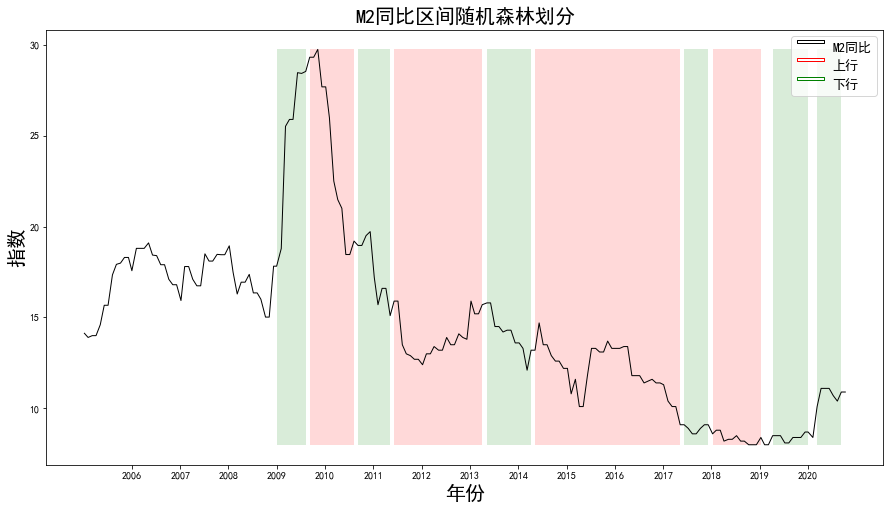

年化收益率 -5.24%
相对收益率 -0.5
准确率 0.479
复杂度 1.812
区间错误率 ('7/15', '108/143')


In [37]:
data_bond = [i[ii*7:(ii*7+7)] for i in df]

rf_prd = []
rf = RandomForestRegressor(n_estimators = 50)
for i in range(47,len(date)):
    cur_ud = und(data[ii][:i],6,24)
    rf.fit(data_bond[:cur_ud.index(0)-11], cur_ud[11:cur_ud.index(0)])
    rf_prd.append(-(-1)**(sum(np.array(rf.predict(data_bond[cur_ud.index(0)-11:i]))) >= 0)  )

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'区间随机森林划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_rf = len(d8) - len(rf_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)


_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)/(profit(data['+ str(ii) +'][l_rf:-24], ud[l_rf:-24])-1),2)')
exec('a'+str(c)+'= round(acc(rf_prd[:-24], ud[l_rf:-24]),3)')
exec('c'+str(c)+'= round(cpx(rf_prd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_rf:], rf_prd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('M2——随机森林')

## 移动平均

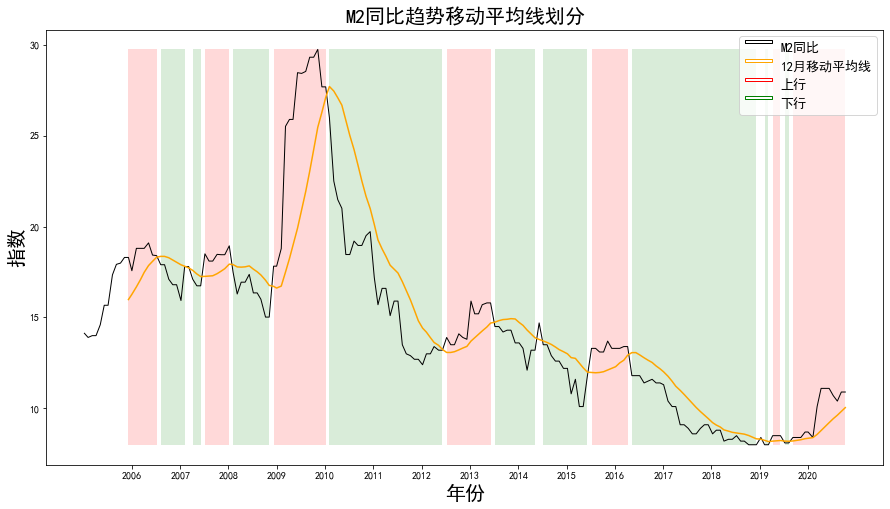

年化收益率 1.75%
相对收益率 0.155
准确率 0.67
复杂度 1.833
区间错误率 ('12/19', '71/179')


In [38]:
ma_b = ma(data[ii],12)
ud_ma_b = comp(data[ii][l-1:],ma_b)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'趋势移动平均线划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8[l-1:], ma(data[ii],l), color = 'orange', label = '12月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_ma_b) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'orange', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data['+ str(ii) +'][l-1:], ud_ma_b)-1) /(profit(data['+ str(ii) +'][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+' = round(acc(ud_ma_b,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_ma_b)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l-1:], ud_ma_b)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('M2——移动平均')

## KST

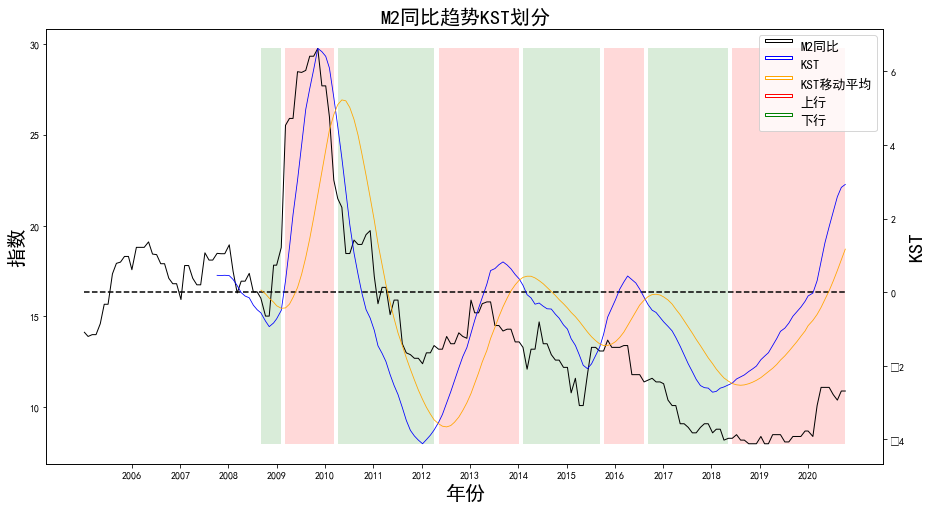

年化收益率 -0.18%
相对收益率 -0.015
准确率 0.514
复杂度 0.946
区间错误率 ('3/8', '33/146')


In [39]:
data_kst = kst(data[ii],9,12,18,24,6,6,6,9)
kst_ma = ma(data_kst,12)
ud_kst = comp(data_kst[11:], kst_ma)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势KST划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])
ax.plot(d8, data[ii], color='blue', linewidth = 0, label = 'KST')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'KST移动平均')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_kst = len(d8) - len(ud_kst)

ax2 = ax.twinx()
ax2.plot(d8[len(d8) - len(data_kst):], data_kst, color='b', linewidth = .8)
ax2.plot(d8[len(d8) - len(kst_ma):], kst_ma, color='orange', linewidth = .8)
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")
plt.ylabel(u'KST',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_kst:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_kst) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l_kst:], ud_kst)-1)*100,2)')
exec('rp'+str(c)+'= round( (profit(data[ii][l_kst:], ud_kst)-1) /(profit(data[ii][l_kst:-24], ud[l_kst:-24])-1)    ,3)')
exec('a'+str(c)+'=round(acc(ud_kst,ud[l_kst:]),3)')
exec('c'+str(c)+'= round(cpx(ud_kst)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l_kst:], ud_kst)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('M2——KST')

## OECD

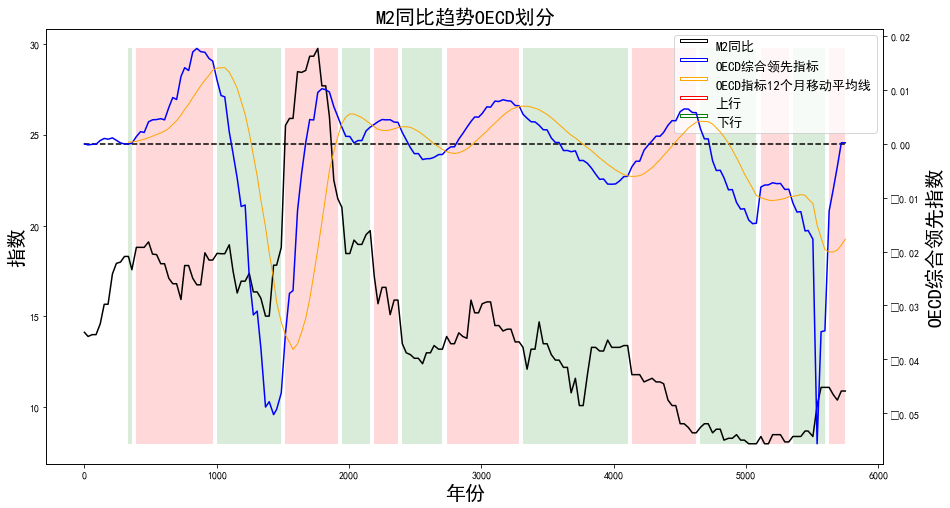

年化收益率 -5.21%
相对收益率 -0.461
准确率 0.413
复杂度 1.351
区间错误率 ('10/14', '134/179')


In [40]:
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1] + '趋势OECD划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1.5, label =int_list[ii][1])
ax.plot(d8, data[ii], color ='blue', linewidth = 0, label = 'OECD综合领先指标')
ax.plot(d8, data[ii], color='orange', linewidth = 0, label = 'OECD指标12个月移动平均线')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

ax2 = ax.twinx()
ax2.plot(d8, oecd, color='b', linewidth = 1.5, label = 'OECD综合领先指标')
ax2.plot(d8[l-1:], oecd_ma, color='orange', linewidth = 1, label = '12个月移动平均线')
plt.hlines(0, d8[0], d8[-1], ls="--",color="black")

plt.ylabel(u'OECD综合领先指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l-1:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud_oecd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue', 'orange','red', 'green']
new_legends = ['-'] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data[ii][l-1:], ud_oecd)-1)/(profit(data[ii][l-1:-24], ud[l-1:-24])-1),3)')
exec('a'+str(c)+'= round(acc(ud_oecd,ud[l-1:]),3)')
exec('c'+str(c)+'= round(cpx(ud_oecd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data[ii][l-1:], ud_oecd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))
name.append('M2——OECD')

## M1随机森林

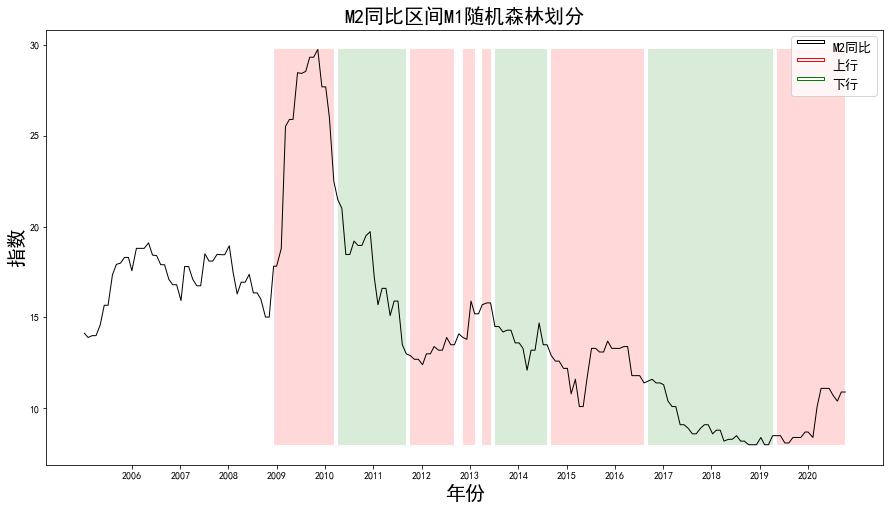

年化收益率 3.58%
相对收益率 0.34
准确率 0.782
复杂度 1.329
区间错误率 ('3/11', '31/143')


In [41]:
ii = 3
data_bond = [i[ii*8:(ii*8+8)] for i in df_st]

rf_prd = []
rf = RandomForestRegressor(n_estimators = 200)
for i in range(47,len(date)):
    cur_ud = und(data[ii][:i],6,24)
    rf.fit(data_bond[:cur_ud.index(0)-11], cur_ud[11:cur_ud.index(0)])
    rf_prd.append(-(-1)**(sum(np.array(rf.predict(data_bond[cur_ud.index(0)-11:i]))) >= 0)  )

ii = 4
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(int_list[ii][1]+'区间M1随机森林划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = int_list[ii][1])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

l_rf = len(d8) - len(rf_prd)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(rf_prd) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)


_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

c += 1

exec('p'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)*100,2)')
exec('rp'+str(c)+'= round((profit(data['+ str(ii) +'][l_rf:],rf_prd)-1)/(profit(data['+ str(ii) +'][l_rf:-24], ud[l_rf:-24])-1),2)')
exec('a'+str(c)+'= round(acc(rf_prd[:-24], ud[l_rf:-24]),3)')
exec('c'+str(c)+'= round(cpx(rf_prd)/base_cpx,3)')
exec('w'+str(c)+'= wrong_div(data['+ str(ii) +'][l_rf:], rf_prd)')

print('年化收益率', str(eval('p'+str(c)))+'%')
print('相对收益率', eval('rp'+str(c)))
print('准确率', eval('a'+str(c)))
print('复杂度', eval('c'+str(c)))
print('区间错误率', eval('w'+str(c)))

name.append('M2——M1随机森林')

# 总结

In [42]:
name.append('平均值')
name.append('中位数')

In [43]:
final_result = []
for i in range(1,c+1):
    final_result.append([eval('p'+str(i)), eval('rp'+str(i)), eval('a'+str(i)), eval('c'+str(i)), eval('w'+str(i))])
final_result.append([round(np.mean([i[0] for i in final_result]),2),np.mean([i[1] for i in final_result]),np.mean([i[2] for i in final_result]),np.mean([i[3] for i in final_result]),''])
final_result.append([round(np.median([i[0] for i in final_result]),2),np.median([i[1] for i in final_result]),
                     np.median([i[2] for i in final_result]),np.median([i[3] for i in final_result]),''])

for i in range(len(final_result)):
    for j in range(len(final_result[0])):
        if j != 4:
            if j == 0:
                final_result[i][j] = str(final_result[i][j])+'%'
            else:
                final_result[i][j] = round(final_result[i][j],2)
table = pd.DataFrame(final_result, 
            index = name
        ,columns=['年化收益率', '相对收益率', '准确度', '复杂度', '区间划分错误率'])
print('区间划分错误率：变化率与涨跌相比错误划分区间数/总划分区间数， 错误划分区间所占时长/总时长')
table

区间划分错误率：变化率与涨跌相比错误划分区间数/总划分区间数， 错误划分区间所占时长/总时长


,年化收益率,相对收益率,准确度,复杂度,区间划分错误率
债券市场——神经网络,2.25%,0.21,0.56,5.74,"(17/32, 53/106)"
债券市场——随机森林,0.08%,0.01,0.54,0.53,"(1/4, 3/143)"
债券市场——移动平均,3.27%,0.26,0.63,2.33,"(11/22, 47/179)"
债券市场——KST,3.18%,0.28,0.57,1.04,"(0/8, 0/146)"
债券市场——OECD,8.15%,0.65,0.81,1.49,"(1/14, 9/179)"
股票市场——神经网络,3.59%,0.23,0.42,3.76,"(10/21, 64/106)"
股票市场——随机森林,1.9%,0.11,0.26,0.53,"(2/4, 57/143)"
股票市场——移动平均,10.86%,0.38,0.64,2.87,"(17/27, 66/179)"
股票市场——KST,1.81%,0.10,0.34,1.04,"(4/8, 57/146)"
股票市场——OECD,13.21%,0.46,0.54,1.49,"(6/14, 78/179)"
